In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [30]:
df = pd.read_csv('PNJ.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2/28/2018 9:15,PNJ,78.14,78.99,78.14,78.99,270,0
2/28/2018 9:16,PNJ,78.94,78.94,78.94,78.94,10,0
2/28/2018 9:19,PNJ,78.14,78.14,78.14,78.14,283,0
2/28/2018 9:20,PNJ,78.14,78.14,78.14,78.14,480,0
2/28/2018 9:21,PNJ,78.14,78.14,78.14,78.14,146,0


In [31]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df = df.resample('12H').mean().dropna()
df.head()

,Close
Date/Time,
2018-02-28 00:00:00,78.716989
2018-03-01 00:00:00,78.770345
2018-03-01 12:00:00,78.386462
2018-03-02 00:00:00,77.176768
2018-03-02 12:00:00,77.438769


In [32]:
scaler = MinMaxScaler(feature_range=(0,1))
df_Close_scaled = scaler.fit_transform(np.array(df.Close).reshape(-1,1))
df_Close_scaled.shape

(1417, 1)

In [33]:
train_size = int(len(df_Close_scaled)*0.65)
test_size = len(df_Close_scaled) - train_size
train_data,test_data = df_Close_scaled[0:train_size,:],df_Close_scaled[train_size:len(df_Close_scaled),:1]

In [34]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [35]:
time_step = 100
X_train, y_train =  create_dataset(train_data,time_step)
X_test, y_test =  create_dataset(test_data,time_step)

In [36]:
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(y_test.shape)

(820, 100)
[[0.64012919 0.64116568 0.63370829 ... 0.73302306 0.75103186 0.82051909]
 [0.64116568 0.63370829 0.61020856 ... 0.75103186 0.82051909 0.82899228]
 [0.63370829 0.61020856 0.61529825 ... 0.82051909 0.82899228 0.82957117]
 ...
 [0.63550711 0.64706802 0.69004264 ... 0.72230686 0.7298212  0.73188236]
 [0.64706802 0.69004264 0.68686098 ... 0.7298212  0.73188236 0.74313802]
 [0.69004264 0.68686098 0.68737727 ... 0.73188236 0.74313802 0.73374865]]
(395, 100)
(395,)


In [37]:
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model .add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model .add(Dropout(0.2))
model .add(LSTM(units = 50, return_sequences = True))
model .add(Dropout(0.2))
model .add(LSTM(units = 50, return_sequences = True))
model .add(Dropout(0.2))
model .add(LSTM(units = 50))
model .add(Dropout(0.2))

model .add(Dense(units = 1))

model .compile(optimizer = 'adam', loss = 'mean_squared_error')

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_8 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_9 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_10 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [39]:
model.fit(X_train, y_train,epochs = 100, batch_size = 64,verbose = 1)

Epoch 1/100
13/13 [==============================] - 6s 28ms/step - loss: 0.0890
Epoch 2/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0186
Epoch 3/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0122
Epoch 4/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0096
Epoch 5/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0097
Epoch 6/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0084
Epoch 7/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0078
Epoch 8/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0075
Epoch 9/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0073
Epoch 10/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0076
Epoch 11/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0066
Epoch 12/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0060
Epoch 13/100
13/13 [=====

In [40]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

13/13 [==============================] - 0s 7ms/step


In [41]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [42]:
print(np.mean((y_train - train_predict)**2))
print(np.mean((y_test  - test_predict)**2))

5547.454816771229
3885.6243642126774


In [43]:
look_back = 100

In [44]:
trainPredictPlot = np.empty_like(df_Close_scaled)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [45]:
testPredictPlot = np.empty_like(df_Close_scaled)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df_Close_scaled) - 1,:] = test_predict

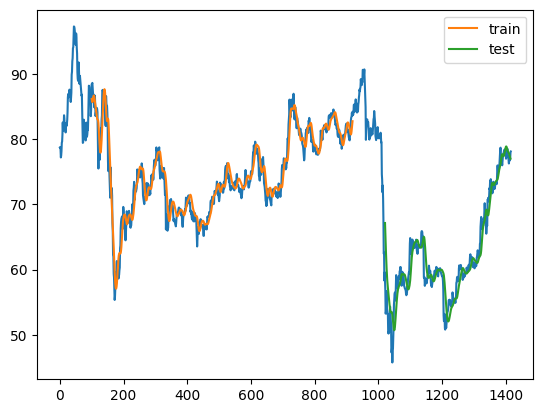

In [46]:
plt.plot(scaler.inverse_transform(df_Close_scaled))
plt.plot(trainPredictPlot, label = 'train')
plt.plot(testPredictPlot, label = 'test')
plt.legend()
plt.show()